In [1]:
import os
import sys
import warnings

os.chdir("../..")
sys.path.append("../../")
warnings.filterwarnings("ignore")

# Simulate single-cell ATAC-seq data

## Introduction

In this example, we show how to use scDesign3Py to simulate the peak by cell matrix of scATAC-seq data.

## Import packages and Read in data

### import pacakges

In [2]:
import anndata as ad
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer
import scDesign3Py

The R project used is located at /home/ld/anaconda3/envs/pyscdesign/lib/R


### Read in the reference data

The raw data is from the [Signac](https://stuartlab.org/signac/articles/pbmc_vignette.html), which is of human peripheral blood mononuclear cells (PBMCs) provided by 10x Genomics. We pre-select the differentially accessible peaks between clusters. The data was converted to `.h5ad` file using the R package `sceasy`.

To save time, we subset 1000 cells and 100 genes

In [3]:
data = ad.read_h5ad("data/ATAC.h5ad")
data = data[data.obs.sample(1000, random_state=123).index,0:100]
data

View of AnnData object with n_obs × n_vars = 1000 × 100
    obs: 'nCount_peaks', 'nFeature_peaks', 'total', 'duplicate', 'chimeric', 'unmapped', 'lowmapq', 'mitochondrial', 'passed_filters', 'cell_id', 'TSS_fragments', 'DNase_sensitive_region_fragments', 'enhancer_region_fragments', 'promoter_region_fragments', 'on_target_fragments', 'blacklist_region_fragments', 'peak_region_fragments', 'nucleosome_signal', 'nucleosome_percentile', 'TSS.enrichment', 'TSS.percentile', 'pct_reads_in_peaks', 'blacklist_ratio', 'peaks_snn_res.0.8', 'seurat_clusters', 'ident', 'cell_type'
    var: 'name'
    obsm: 'X_lsi', 'X_umap'

## Simulation

Here we choose the Zero-inflated Poisson (ZIP) as the distribution due to its good empirical performance. Users may explore other distributions (Poisson, NB, ZINB) since there is no conclusion on the best distribution of ATAC-seq.

In [4]:
test = scDesign3Py.scDesign3(n_cores=3,parallelization="pbmcmapply")
test.set_r_random_seed(123)
simu_res = test.scdesign3(
    anndata=data,
    default_assay_name="counts",
    celltype="cell_type",
    mu_formula="cell_type",
    sigma_formula="1",
    family_use="zip",
    usebam=False,
    corr_formula="cell_type",
    copula="gaussian",
)

R[write to console]: Input Data Construction Start

R[write to console]: Input Data Construction End

R[write to console]: Start Marginal Fitting



  |=======================================================| 100%, Elapsed 03:11


R[write to console]: Marginal Fitting End

R[write to console]: Start Copula Fitting

R[write to console]: Convert Residuals to Multivariate Gaussian



  |=======================================================| 100%, Elapsed 00:07


R[write to console]: Converting End

R[write to console]: Copula group CD14 Mono starts

R[write to console]: Copula group CD4 Naive starts

R[write to console]: Copula group DN T starts

R[write to console]: Copula group NK CD56Dim starts

R[write to console]: Copula group pre-B starts

R[write to console]: Copula group CD8 Naive starts

R[write to console]: Copula group CD8 Effector starts

R[write to console]: Copula group pro-B starts

R[write to console]: Copula group CD4 Memory starts

R[write to console]: Copula group CD16 Mono starts

R[write to console]: Copula group DC starts

R[write to console]: Copula group pDC starts

R[write to console]: Copula group NK CD56bright starts

R[write to console]: Copula Fitting End

R[write to console]: Start Parameter Extraction



  |=======================================================| 100%, Elapsed 00:05


R[write to console]: Parameter
Extraction End

R[write to console]: Start Generate New Data

R[write to console]: Use Copula to sample a multivariate quantile matrix

R[write to console]: Sample Copula group CD14 Mono starts

R[write to console]: Sample Copula group CD4 Naive starts

R[write to console]: Sample Copula group DN T starts

R[write to console]: Sample Copula group NK CD56Dim starts

R[write to console]: Sample Copula group pre-B starts

R[write to console]: Sample Copula group CD8 Naive starts

R[write to console]: Sample Copula group CD8 Effector starts

R[write to console]: Sample Copula group pro-B starts

R[write to console]: Sample Copula group CD4 Memory starts

R[write to console]: Sample Copula group CD16 Mono starts

R[write to console]: Sample Copula group DC starts

R[write to console]: Sample Copula group pDC starts

R[write to console]: Sample Copula group NK CD56bright starts



  |=======================================================| 100%, Elapsed 00:00


R[write to console]: New Data Generating End



We also run the TF-IDF transformation.

In [5]:
tfidf = TfidfTransformer()
org_tfidf = tfidf.fit_transform(data.X)
simu_tfidf = tfidf.fit_transform(simu_res["new_count"])

Then we can construct new data using the simulated count matrix and add the `tfidf` layer.

In [6]:
simu_data = ad.AnnData(X=simu_res["new_count"], obs=simu_res["new_covariate"], layers={"tfidf": simu_tfidf})
data.layers["tfidf"] = org_tfidf

## Visualization


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

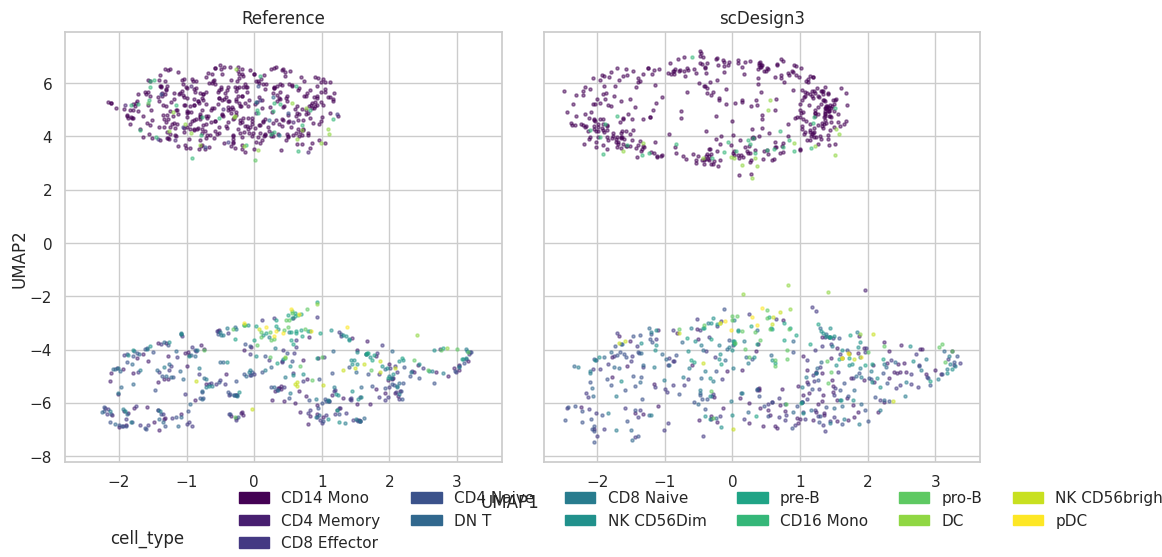

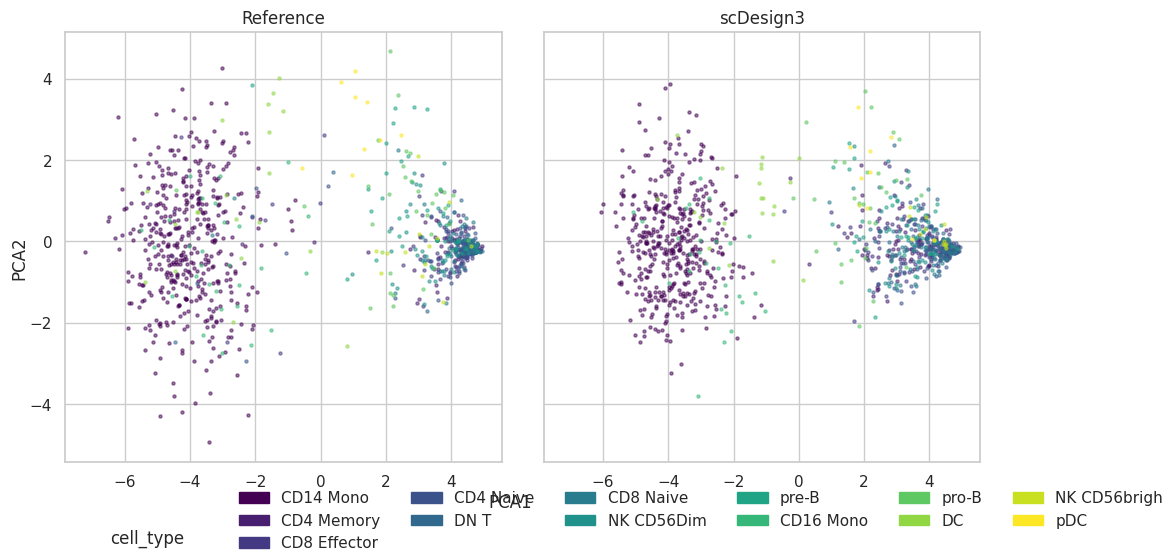

In [7]:
plot = scDesign3Py.plot_reduceddim(
    ref_anndata=data,
    anndata_list=simu_data,
    name_list=["Reference", "scDesign3"],
    assay_use="tfidf",
    if_plot=True,
    color_by="cell_type",
    n_pc=20,
    point_size=5,
)

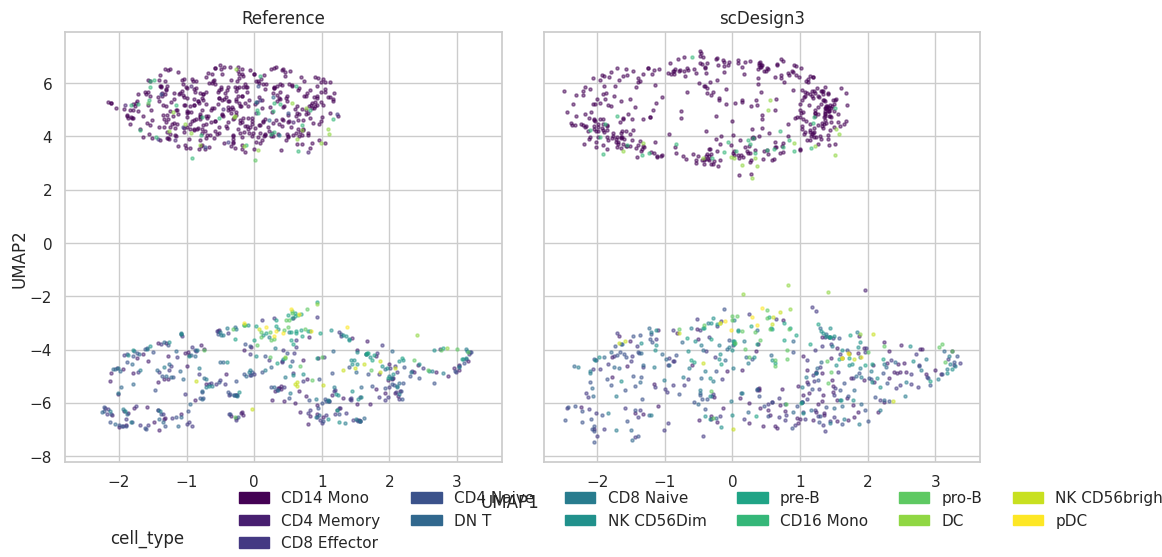

In [8]:
plot["p_umap"]